# Histogram over t=200-390 Myr of the local SFR surface density¶

In [1]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import math

sys.path.insert(0,'..')
import pyathena as pa

import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll

models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')



LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
/home/comejuliet/miniconda3/envs/pyathena/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WA

In [21]:
s = ncr
h = s.read_hst()

# define the domain and the size of the xaxis bins
Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
w = Lx/15

# check which time snapshots are available
print(s.nums)
nsnap = s.nums[-1]-s.nums[0]
print(h['time'])
print(nsnap)

# build a function for reading starpar files

def sp_reader(number):
    
    sp = s.load_starpar_vtk(num=number)
    sp['mage'] *= s.u.Myr
    sp['mass'] *= s.u.Msun
    sp['x1'] *= s.u.pc
    sp['x2'] *= s.u.pc
    # first, select only young star particles
    # "young" is a boolean array: True for young, False for old
    young = sp['age'] < 40.
    # second, separate clusters (mass != 0) and runaways (mass == 0)
    # mass of runaway OB stars was set to zero
    # "runaway" and "cluster" are also boolean arrays
    runaway=sp['mass'] == 0
    cluster=sp['mass'] != 0

    # young * cluster is True for young and cluster particles
    young_cluster = young & cluster
    spyoung = sp[young_cluster]

    # change to sp if you want to plot star particles of all ages
    return spyoung

sptot = []
for i in range (210,700):   #how to write the snapshot times in a general way?
    sptot.append(sp_reader(i))

# making a histogram of the total star mass in each x axis bin, for each snapshot 
Msp = np.zeros((nsnap,15))
xbin = np.zeros((nsnap,16))

for i in range (nsnap):
    (Msp[i,:], xbin[i,:]) = np.histogram(sptot[i].x1, bins=15, range = (-Lx/2, Lx/2), weights=sptot[i].mass)
      
# calculating sigma_SFR in each bin, for each snapshot
sigma_SFR = []

# remember to change agemax if you're plotting different populations 
agemax = 40  
for i in range (nsnap):
    sigma_SFR.append(Msp[i,:]/(agemax*w*Ly))


# defining the minimum and maximum value of the SFR surface density 
min_logSFR_x =[]
max_logSFR_x = []

sigma_SFR_cal = np.zeros(nsnap, dtype=object)
for i in range (nsnap):
        # exclude the zero SFR points to avoid - inf in min
        sigma_SFR_cal[i] = [j for j in sigma_SFR[i] if j!= 0]
        max_logSFR_x.append(max(np.log10(sigma_SFR_cal[i])))
        min_logSFR_x.append(min(np.log10(sigma_SFR_cal[i])))
                        
max_logSFR = max(max_logSFR_x)   
min_logSFR = min(min_logSFR_x)

# binning again the values of sigma_SFR at all times in each bin to find the frequency associated with each value
sigma_SFR_x = np.zeros((15,nsnap))
for i in range (nsnap):
    sigma_SFR_x[:,i] = np.log10(sigma_SFR[i][:])
    
sigma_SFRx_binned = []
for i in range (15):
    sigma_SFRx_binned.append(np.histogram(sigma_SFR_x[i,:],bins=100,range=(min_logSFR,max_logSFR)))
    
sfr2d = np.zeros((100,15))
for i in range (15):
    sfr2d[:,i] = sigma_SFRx_binned[i][0]


# finding the median value for overplot 
import statistics 
sigma_SFR_matrix = np.zeros((15,nsnap))
idx = [0.0]*15
sigma_SFR_median_ncr = np.zeros(15)
sigmaSFR_nonzero = [0.0]*15

for j in range (nsnap):
    sigma_SFR_matrix[:,j] = sigma_SFR[j]

for i in range(15):
    idx[i] = np.where(sigma_SFR_matrix[i,:] != 0) 
    sigmaSFR_nonzero[i] = sigma_SFR_matrix[i,idx[i]]
    sigma_SFR_median_ncr[i] = statistics.median(sigmaSFR_nonzero[i][0])
print(sigma_SFR_median_ncr)

# build a new grid on the x axis for plotting the median value
xbin_median = np.zeros(15)
for i in range(15):
    xbin_median[i] = xbin[1,i] + Lx/(15*2)   
print(xbin_median/1000)

[210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700]
time_code
0.000000        0.000000
0.014534        0.014211
0.020292        0.019841
0.032054        0.031343
0.044298        0.043314
                 ...    
699.962149    684.417545
699.971018    684.426216
699.980046    684.435045
699.991439    684.446184
700.000000    684.454555
Name: time, Length: 70004, dtype: float64
490
[0.00060791 0.0005587  0.0005152  0.00049741 0.00054941 0.00063794
 0.0008881  0.00358846 0.01212687 0.01456443 0.0103272  0.00375894
 0.00209354 0.00089971 0.00065047]
[-9.55733333e-01 -8.19200000e-01 -6.82666667e-01 -5.46133333e-01
 -4.09600000e-01 -2.73066667e-01 -1.36533333e-01  1.42108547e-17
  1.36533333e-01  2.73066667e-01  4.09600000e-01  5.46133333e-01
  6.82666667e-01  8.19200000e-01  9.55733333e-01]


In [22]:
nsnap

490

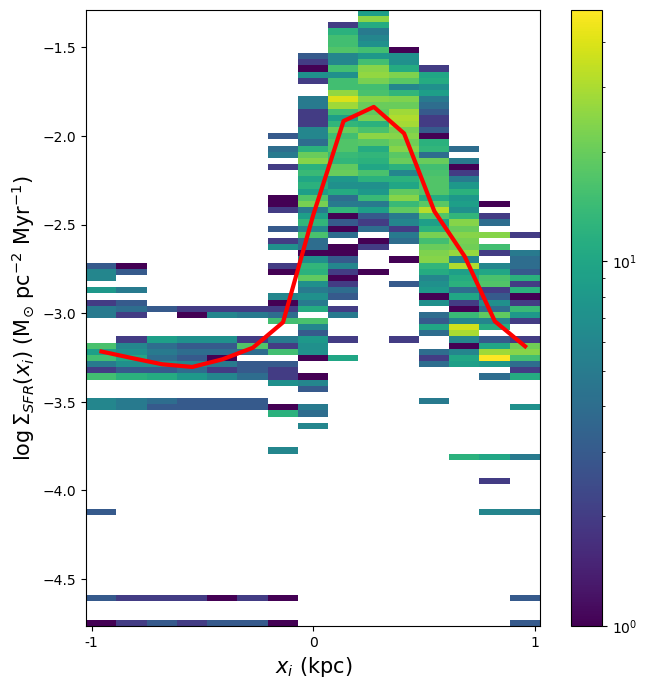

In [9]:
plt.figure(3,figsize=(8,8))
plt.imshow(sfr2d, norm=LogNorm(),extent=(-1.024,1.024,max_logSFR,min_logSFR), aspect =0.8)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\log{\Sigma_{SFR}(x_{i})}$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_ncr), color='red', linewidth=3)
plt.xticks(ticks=[-1.0,0.0,1.0], labels=[-1,0,1])
plt.show()

In [11]:
s = classic
h = s.read_hst()

# define the domain and the size of the xaxis bins
Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
w = Lx/15

# check which time snapshots are available
print(s.nums)
nsnap = s.nums[-1]-s.nums[0]
print(h['time'])
print(nsnap)

# build a function for reading starpar files

def sp_reader(number):
    
    sp = s.load_starpar_vtk(num=number)
    sp['mage'] *= s.u.Myr
    sp['mass'] *= s.u.Msun
    sp['x1'] *= s.u.pc
    sp['x2'] *= s.u.pc
    # first, select only young star particles
    # "young" is a boolean array: True for young, False for old
    young = sp['age'] < 40.
    # second, separate clusters (mass != 0) and runaways (mass == 0)
    # mass of runaway OB stars was set to zero
    # "runaway" and "cluster" are also boolean arrays
    runaway=sp['mass'] == 0
    cluster=sp['mass'] != 0

    # young * cluster is True for young and cluster particles
    young_cluster = young & cluster
    spyoung = sp[young_cluster]

    # change to sp if you want to plot star particles of all ages
    return spyoung

sptot = []
for i in range (210,470):   #how to write the snapshot times in a general way?
    sptot.append(sp_reader(i))

# making a histogram of the total star mass in each x axis bin, for each snapshot 
Msp = np.zeros((nsnap,15))
xbin = np.zeros((nsnap,16))

for i in range (nsnap):
    (Msp[i,:], xbin[i,:]) = np.histogram(sptot[i].x1, bins=15, range = (-Lx/2, Lx/2), weights=sptot[i].mass)
      
# calculating sigma_SFR in each bin, for each snapshot
sigma_SFR = []

# remember to change agemax if you're plotting different populations 
agemax = 40  
for i in range (nsnap):
    sigma_SFR.append(Msp[i,:]/(agemax*w*Ly))


# defining the minimum and maximum value of the SFR surface density 
min_logSFR_x =[]
max_logSFR_x = []

sigma_SFR_cal = np.zeros(nsnap, dtype=object)
for i in range (nsnap):
        # exclude the zero SFR points to avoid - inf in min
        sigma_SFR_cal[i] = [j for j in sigma_SFR[i] if j!= 0]
        max_logSFR_x.append(max(np.log10(sigma_SFR_cal[i])))
        min_logSFR_x.append(min(np.log10(sigma_SFR_cal[i])))
                        
max_logSFR = max(max_logSFR_x)   
min_logSFR = min(min_logSFR_x)

# binning again the values of sigma_SFR at all times in each bin to find the frequency associated with each value
sigma_SFR_x = np.zeros((15,nsnap))
for i in range (nsnap):
    sigma_SFR_x[:,i] = np.log10(sigma_SFR[i][:])
    
sigma_SFRx_binned = []
for i in range (15):
    sigma_SFRx_binned.append(np.histogram(sigma_SFR_x[i,:],bins=100,range=(min_logSFR,max_logSFR)))
    
sfr2d = np.zeros((100,15))
for i in range (15):
    sfr2d[:,i] = sigma_SFRx_binned[i][0]


# finding the median value for overplot 
import statistics 
sigma_SFR_matrix = np.zeros((15,nsnap))
idx = [0.0]*15
sigma_SFR_median_classic = np.zeros(15)
sigmaSFR_nonzero = [0.0]*15

for j in range (nsnap):
    sigma_SFR_matrix[:,j] = sigma_SFR[j]

for i in range(15):
    idx[i] = np.where(sigma_SFR_matrix[i,:] != 0) 
    sigmaSFR_nonzero[i] = sigma_SFR_matrix[i,idx[i]]
    sigma_SFR_median_classic[i] = statistics.median(sigmaSFR_nonzero[i][0])
print(sigma_SFR_median_classic)

# build a new grid on the x axis for plotting the median value
xbin_median = np.zeros(15)
for i in range(15):
    xbin_median[i] = xbin[1,i] + Lx/(15*2)   
print(xbin_median/1000)

[210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470]
time_code
0.000000        0.000000
0.014534        0.014211
0.020292        0.019841
0.032054        0.031343
0.044298        0.043314
                 ...    
477.480029    466.876258
477.490038    466.886045
477.500174    466.895956
477.510716    466.906263
477.516740    466.912154
Name: time, Length: 47756, dtype: float64
260
[0.00033769 0.00139023 0.00139023 0.00100442 0.0007511  0.00075869
 0.00268593 0.01054793 0.0291279  0.02946664 0.00853382 0.00209157
 0.00164895 0.00078091 0.00083508]
[-9.55733333e-01 -8.19200000e-01 -6.82666667e-01 -5.46133333e-01
 -4.09600000e-01 -2.73066667e-01 -1.36533333e-01  1.42108547e-17
  1.36533333e-01  2.73066667e-01  4.09600000e-01  5.46133333e-01
  6.82666667e-01  8.19200000e-01  9.55733333e-01]


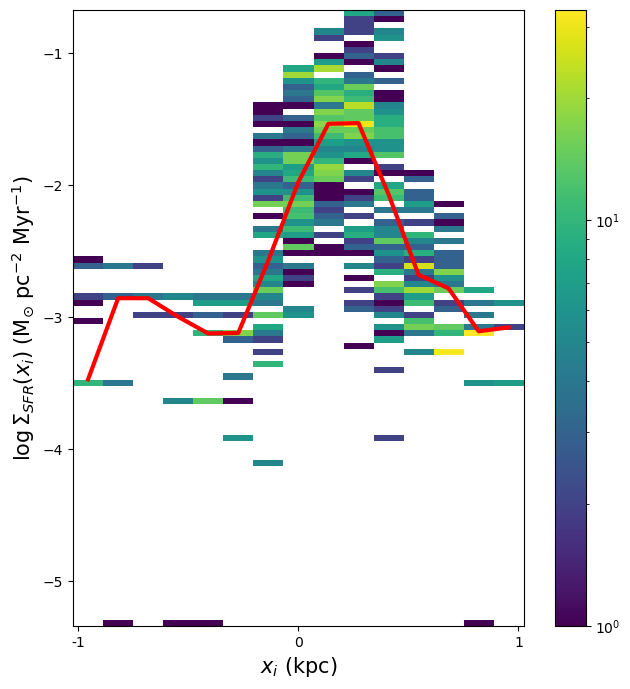

In [15]:
plt.figure(3,figsize=(8,8))
plt.imshow(sfr2d, norm=LogNorm(),extent=(-1.024,1.024,max_logSFR,min_logSFR),aspect=0.6)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\log{\Sigma_{SFR}(x_{i})}$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_classic), color='red', linewidth=3)
plt.xticks(ticks=[-1.0,0.0,1.0], labels=[-1,0,1])
plt.show()

In [16]:
s = no_spiral
h = s.read_hst()

# define the domain and the size of the xaxis bins
Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
w = Lx/15

# check which time snapshots are available
print(s.nums)
nsnap = s.nums[-1]-s.nums[0]
print(h['time'])
print(nsnap)

# build a function for reading starpar files

def sp_reader(number):
    
    sp = s.load_starpar_vtk(num=number)
    sp['mage'] *= s.u.Myr
    sp['mass'] *= s.u.Msun
    sp['x1'] *= s.u.pc
    sp['x2'] *= s.u.pc
    # first, select only young star particles
    # "young" is a boolean array: True for young, False for old
    young = sp['age'] < 40.
    # second, separate clusters (mass != 0) and runaways (mass == 0)
    # mass of runaway OB stars was set to zero
    # "runaway" and "cluster" are also boolean arrays
    runaway=sp['mass'] == 0
    cluster=sp['mass'] != 0

    # young * cluster is True for young and cluster particles
    young_cluster = young & cluster
    spyoung = sp[young_cluster]

    # change to sp if you want to plot star particles of all ages
    return spyoung

sptot = []
for i in range (200,460):   #how to write the snapshot times in a general way?
    sptot.append(sp_reader(i))

# making a histogram of the total star mass in each x axis bin, for each snapshot 
Msp = np.zeros((nsnap,15))
xbin = np.zeros((nsnap,16))

for i in range (nsnap):
    (Msp[i,:], xbin[i,:]) = np.histogram(sptot[i].x1, bins=15, range = (-Lx/2, Lx/2), weights=sptot[i].mass)
      
# calculating sigma_SFR in each bin, for each snapshot
sigma_SFR = []

# remember to change agemax if you're plotting different populations 
agemax = 40  
for i in range (nsnap):
    sigma_SFR.append(Msp[i,:]/(agemax*w*Ly))


# defining the minimum and maximum value of the SFR surface density 
min_logSFR_x =[]
max_logSFR_x = []

sigma_SFR_cal = np.zeros(nsnap, dtype=object)
for i in range (nsnap):
        # exclude the zero SFR points to avoid - inf in min
        sigma_SFR_cal[i] = [j for j in sigma_SFR[i] if j!= 0]
        max_logSFR_x.append(max(np.log10(sigma_SFR_cal[i])))
        min_logSFR_x.append(min(np.log10(sigma_SFR_cal[i])))
                        
max_logSFR = max(max_logSFR_x)   
min_logSFR = min(min_logSFR_x)

# binning again the values of sigma_SFR at all times in each bin to find the frequency associated with each value
sigma_SFR_x = np.zeros((15,nsnap))
for i in range (nsnap):
    sigma_SFR_x[:,i] = np.log10(sigma_SFR[i][:])
    
sigma_SFRx_binned = []
for i in range (15):
    sigma_SFRx_binned.append(np.histogram(sigma_SFR_x[i,:],bins=100,range=(min_logSFR,max_logSFR)))
    
sfr2d = np.zeros((100,15))
for i in range (15):
    sfr2d[:,i] = sigma_SFRx_binned[i][0]


# finding the median value for overplot 
import statistics 
sigma_SFR_matrix = np.zeros((15,nsnap))
idx = [0.0]*15
sigma_SFR_median_nospiral = np.zeros(15)
sigmaSFR_nonzero = [0.0]*15

for j in range (nsnap):
    sigma_SFR_matrix[:,j] = sigma_SFR[j]

for i in range(15):
    idx[i] = np.where(sigma_SFR_matrix[i,:] != 0) 
    sigmaSFR_nonzero[i] = sigma_SFR_matrix[i,idx[i]]
    sigma_SFR_median_nospiral[i] = statistics.median(sigmaSFR_nonzero[i][0])
print(sigma_SFR_median_nospiral)

# build a new grid on the x axis for plotting the median value
xbin_median = np.zeros(15)
for i in range(15):
    xbin_median[i] = xbin[1,i] + Lx/(15*2)   
print(xbin_median/1000)

[200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460]
time_code
200.000000    195.558444
200.010217    195.568434
200.021186    195.579160
200.031324    195.589072
200.040412    195.597959
                 ...    
464.250980    453.940997
464.260672    453.950474
464.270349    453.959936
464.280027    453.969399
464.282449    453.971767
Name: time, Length: 26430, dtype: float64
260
[0.00456575 0.00532276 0.00413455 0.00376885 0.00302355 0.0039071
 0.00297408 0.00306056 0.00244528 0.00305623 0.00178513 0.00110617
 0.00218311 0.00281993 0.0029805 ]
[-9.55733333e-01 -8.19200000e-01 -6.82666667e-01 -5.46133333e-01
 -4.09600000e-01 -2.73066667e-01 -1.36533333e-01  1.42108547e-17
  1.36533333e-01  2.73066667e-01  4.09600000e-01  5.46133333e-01
  6.82666667e-01  8.19200000e-01  9.55733333e-01]


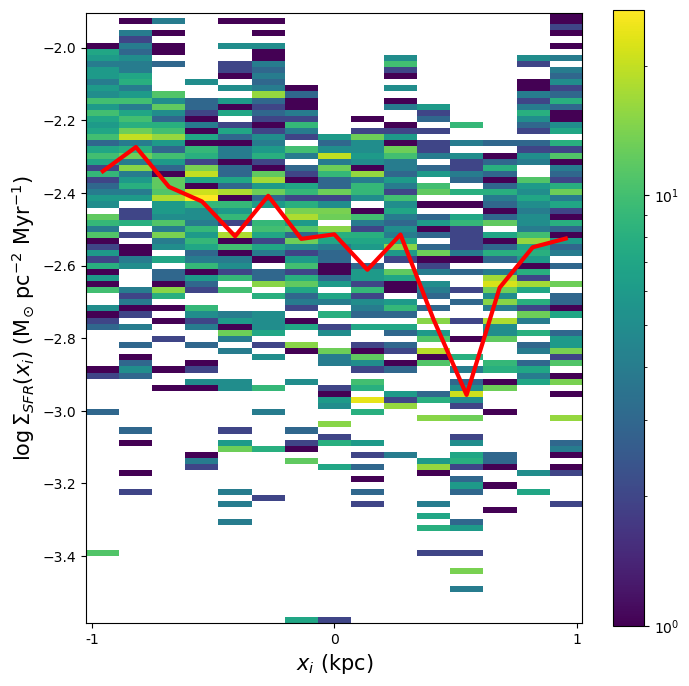

In [18]:
plt.figure(3,figsize=(8,8))
plt.imshow(sfr2d, norm=LogNorm(),extent=(-1.024,1.024,max_logSFR,min_logSFR),aspect=1.5)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\log{\Sigma_{SFR}(x_{i})}$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_nospiral), color='red', linewidth=3)
plt.xticks(ticks=[-1.0,0.0,1.0], labels=[-1,0,1])
plt.show()

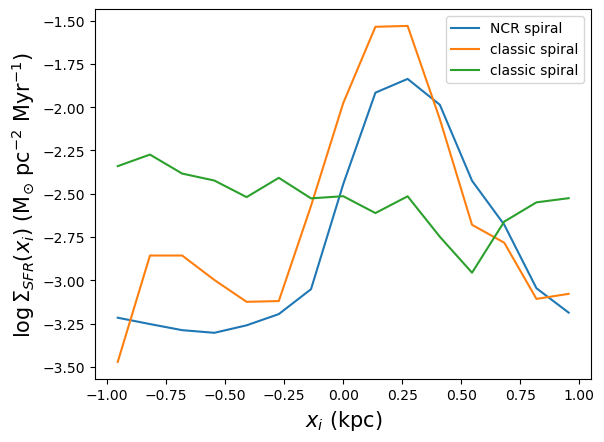

In [19]:
# COMPARISON

plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_ncr), label= 'NCR spiral')
plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_classic), label = 'classic spiral')
plt.plot(xbin_median/1000,np.log10(sigma_SFR_median_nospiral), label = 'classic spiral')
plt.xlabel(r'$x_{i}$ (kpc)',fontsize=15)
plt.ylabel(r'$\log{\Sigma_{SFR}(x_{i})}$ (M$_{\odot}$ pc$^{-2}$ Myr$^{-1}$)',fontsize=15)
plt.legend()